# GATv2

After GAT, Brody et al. (2021) illustrate a confined form of attention that is computed by the graph attention network (GAT) - the ranking of the attention scores is unconditioned on the query node. This constrained form of attention is formally defined as static attention and is distinguished from a more flexible form of attention called dynamic attention. The static attention mechanism impairs the ability of GAT to accurately model the training data. To overcome this limitation, the authors propose GATv2 in 2022, a variant of dynamic graph attention that offers enhanced expressive power compared to GAT. The fixed version of the graph attention mechanism becomes

$$
\alpha_{un} = \frac{
\text{exp} \left( \vec{\textbf{a}}^\textbf{T} \text{LeakyReLu} \left(  \textbf{W} \left[ u || n \right] \right) \right)
}{
\sum_{v\in \mathcal{N}(u)} \text{exp} \left( \vec{\textbf{a}}^\textbf{T} \text{LeakyReLu} \left( \textbf{W} \left[ u || v \right] \right) \right) }
$$

which makes a significant difference in the expressiveness of the attention function - *A GATv2 layer computes dynamic attention for any set of node representations $\mathbb{K} = \mathbb{Q} = \mathcal{V}$* Brody et al. (2021) where $\mathbb{K}$ is a set of key vectors and $\mathbb{Q}$ is a set of query vectors.

In [1]:
import sys

sys.path.insert(0, '..')

In [3]:
from data.dataset import Dataset
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.DGLModel import DGLModel
from model.abstractmodel import AbstractModel
from ray import tune
import pandas as pd
import torch

In [4]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST1 = Dataset.load_csv("ds/TST_1")
TST2 = Dataset.load_csv("ds/TST_2")

In [5]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST1.X = TST1.featurize(featurizer)
TST2.X = TST2.featurize(featurizer)

In [6]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [5]:
RANDOM_STATE = 1234
SPACE = {
    "hidden_feats": tune.choice([[32, 32], [64, 64], [64, 64, 64], [64, 128], [64, 128, 256]]),
    "num_heads": tune.randint(4, 6),
    "feat_drops": tune.uniform(0, 1),
    "attn_drops": tune.uniform(0, 1),
    "alphas": tune.uniform(0, 1),
    "residuals": tune.choice([True, False]),
    "biases": tune.choice([True, False]),
    "agg_modes": tune.choice(["flatten", "mean"]),
    "lr": tune.choice([0.1, 0.01, 0.001]),
    "epoch": tune.choice([100, 150, 200, 250, 300]),
    "weight_decay": tune.uniform(0, 1),
    "allow_zero_in_degree": tune.choice([True, False]),
    "share_weights": tune.choice([True, False]),
}

In [6]:
from model.dgl.GATv2 import GATv2
import numpy as np


def trainable_func(config: dict, dataset: Dataset):
    AbstractModel.set_seed(RANDOM_STATE)
    trn, val = dataset.split()
    try:
        model = GATv2(
            task_type="regression",
            # GATv2 Configuration
            n_tasks=1,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=config["hidden_feats"],
            num_heads=config["num_heads"],
            feat_drops=config["feat_drops"],
            attn_drops=config["attn_drops"],
            alphas=config["alphas"],
            residuals=config["residuals"],
            biases=config["biases"],
            agg_modes=config["agg_modes"],
            allow_zero_in_degree=config["allow_zero_in_degree"],
            share_weights=config["share_weights"],
            predictor_out_feats=128,
            predictor_dropout=0,
            get_attention=False,
            # Abstract DGL Configuration
            lr=config["lr"],
            y_name="LogS exp (mol/L)",
            weight_decay=config["weight_decay"],
            batch_size=4096,
            verbose=False
        )
        scores = model.fit(trn, val=val, epochs=config["epoch"], verbose=False)
        tune.report(rmse=np.average(scores["rmse"]))
    except Exception as e:
        print(f"{e}. Config: {config}\nSkip this trail")

In [7]:
from ray.tune.search import BasicVariantGenerator

tuner = DGLModel.tuner(
    trainable_func,
    SPACE,
    num_samples=50,
    search_alg=BasicVariantGenerator(max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

2023-03-15 12:42:47,412	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_e1201_00000,2023-03-15_12-44-19,False,,80149b2c978a483bb3048768c347c202,64-4090-13700K,1,127.0.0.1,29972,2.82798,85.3915,85.3915,85.3915,1678884259,0,,1,e1201_00000,0.0045042


2023-03-15 13:35:34,392	INFO tune.py:798 -- Total run time: 3163.50 seconds (3163.41 seconds for the tuning loop).


In [8]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'hidden_feats': [32, 32],
 'num_heads': 5,
 'feat_drops': 0.32240039686671307,
 'attn_drops': 0.11604726647525376,
 'alphas': 0.18398160084718762,
 'residuals': False,
 'biases': True,
 'agg_modes': 'flatten',
 'lr': 0.01,
 'epoch': 300,
 'weight_decay': 0.11045228596722756,
 'allow_zero_in_degree': False,
 'share_weights': False}

In [5]:
from model.dgl.GATv2 import GATv2

MODEL = GATv2(
    task_type="regression",
    # GATv2 Configuration
    n_tasks=1,
    in_feats=featurizer.get_node_feat_size(),
    hidden_feats=[32, 32],
    num_heads=5,
    feat_drops=0.32240039686671307,
    attn_drops=0.11604726647525376,
    alphas=0.18398160084718762,
    residuals=False,
    biases=True,
    agg_modes="flatten",
    allow_zero_in_degree=False,
    share_weights=False,
    predictor_out_feats=128,
    predictor_dropout=0,
    get_attention=False,
    # Abstract DGL Configuration
    lr=0.001,
    y_name="LogS exp (mol/L)",
    weight_decay=0.11045228596722756,
    batch_size=4096,
    verbose=False
)
trn, val = TRN.split()
scores = MODEL.fit(trn, val=val, epochs=300)

100%|██████████| 300/300 [01:59<00:00,  2.50it/s, loss: 1.650 rmse: 1.293]


<AxesSubplot: >

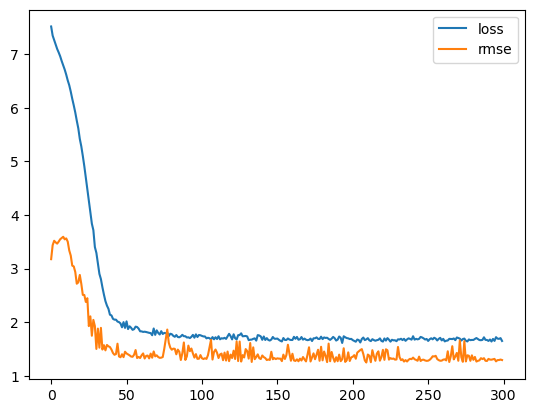

In [6]:
pd.DataFrame({
    "loss": [v.item() for v in MODEL.scores["loss"]],
    "rmse": [v.item() for v in MODEL.scores["rmse"]]
}).plot()

In [7]:
result = MODEL.cross_validate(
    dataset=TRN,
    epochs=300,
    extra_eval_set=TST1,
    cv=4,
    verbose=True
)

[CV 3]: 100%|██████████| 300/300 [01:32<00:00,  3.25it/s, loss: 1.367, val_rmse: 1.026]


In [8]:
np.std(result["rmse"]), np.mean(result["rmse"])

(0.75028455, 1.6959947)

In [9]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, MODEL.predict(TST1).cpu(), squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, MODEL.predict(TST2).cpu(), squared=False)}")

TST1 : RMSE 0.9594392235163333
TST2 : RMSE 1.5766736978189355


In [5]:
SPACE = {
    "num_heads": tune.uniform(4, 8),
    "feat_drops": tune.uniform(0.1, 0.5),
    "attn_drops": tune.uniform(0, 0.2),
    "alphas": tune.uniform(0, 0.3),
    "epoch": tune.uniform(100, 500),
    "weight_decay": tune.uniform(0, 0.3),
}

In [10]:
from model.dgl.GATv2 import GATv2


def trainable_func(config: dict, dataset: Dataset):
    trn, val = dataset.split()
    try:
        model = GATv2(
            task_type="regression",
            # GATv2 Configuration
            n_tasks=1,
            in_feats=featurizer.get_node_feat_size(),
            hidden_feats=[32, 32],
            num_heads=int(config["num_heads"]),
            feat_drops=config["feat_drops"],
            attn_drops=config["attn_drops"],
            alphas=config["alphas"],
            residuals=False,
            biases=True,
            agg_modes="flatten",
            allow_zero_in_degree=False,
            share_weights=False,
            predictor_out_feats=128,
            predictor_dropout=0,
            get_attention=False,
            # Abstract DGL Configuration
            lr=0.001,
            y_name="LogS exp (mol/L)",
            weight_decay=config["weight_decay"],
            batch_size=4096,
            verbose=False
        )
        scores = model.fit(trn, val=val, epochs=int(config["epoch"]), verbose=False)
        tune.report(rmse=np.average(scores["rmse"]))
    except Exception as e:
        print(f"{e}. Config: {config}\nSkip this trail")

In [11]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search import ConcurrencyLimiter

tuner = DGLModel.tuner(
    trainable_func,
    space=SPACE,
    num_samples=50,
    search_alg=ConcurrencyLimiter(BayesOptSearch(metric="rmse", mode="min"), max_concurrent=1),
    dataset=TRN
)
tune_result = tuner.fit()

Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,rmse,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
trainable_func_ea672777,2023-03-15_16-08-42,False,,57f09340fcf84ebe843a2bfe4bdfa14e,64-4090-13700K,1,127.0.0.1,13776,1.45708,113.286,113.286,113.286,1678896522,0,,1,ea672777,0.0041697


2023-03-15 17:27:46,433	INFO tune.py:798 -- Total run time: 4859.91 seconds (4859.90 seconds for the tuning loop).


In [12]:
best_result = tune_result.get_best_result(metric="rmse", mode="min")
best_result.config

{'num_heads': 4.393820730206258,
 'feat_drops': 0.10594214416835764,
 'attn_drops': 0.014153746739612139,
 'alphas': 0.274140484462043,
 'epoch': 415.6929830665918,
 'weight_decay': 0.04639076326774522}

In [18]:
from model.dgl.GATv2 import GATv2

num_heads = 4
AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = GATv2(
        task_type="regression",
        # GATv2 Configuration
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        hidden_feats=[32, 32 * num_heads],
        num_heads=4,
        feat_drops=0.10594214416835764,
        attn_drops=0.014153746739612139,
        alphas=0.274140484462043,
        residuals=False,
        biases=True,
        agg_modes="flatten",
        allow_zero_in_degree=False,
        share_weights=False,
        predictor_out_feats=128,
        predictor_dropout=0,
        get_attention=False,
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0.04639076326774522,
        batch_size=4096,
    )
    model.fit(trn, val=val, epochs=800, min_epoch=200, early_stop=20)

    k_pred_tst1.append(model.predict(TST1).cpu())
    k_pred_tst2.append(model.predict(TST2).cpu())

[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 31%|███       | 245/800 [01:38<03:42,  2.49it/s, loss: 1.532 rmse: 1.131]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 29%|██▉       | 234/800 [01:44<04:12,  2.24it/s, loss: 1.223 rmse: 1.981]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 32%|███▏      | 253/800 [01:48<03:55,  2.32it/s, loss: 1.272 rmse: 1.437]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 29%|██▉       | 235/800 [01:41<04:03,  2.32it/s, loss: 1.398 rmse: 0.872]


[INFO] Expect to use 'DGL_Graph' to featurize SMILES
[INFO] Device cuda


 30%|██▉       | 237/800 [01:41<04:00,  2.34it/s, loss: 1.381 rmse: 1.012]


In [19]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]
pred_tst2 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst2, 1)]

In [20]:
print(f"TST1 : RMSE {mean_squared_error(TST1.y, pred_tst1, squared=False)}")
print(f"TST2 : RMSE {mean_squared_error(TST2.y, pred_tst2, squared=False)}")

TST1 : RMSE 0.9193128958155456
TST2 : RMSE 1.3997682122352413


In [21]:
print(f"TST1 : R^2 {r2_score(TST1.y, pred_tst1)}")
print(f"TST2 : R^2 {r2_score(TST2.y, pred_tst2)}")

TST1 : R^2 0.47259831230778304
TST2 : R^2 0.5728433107058166


Text(0.5, 1.0, '2019 Solubility Challenge Test Set 2 (GATv2)\nRMSE: 1.400, $R^2$: 0.573')

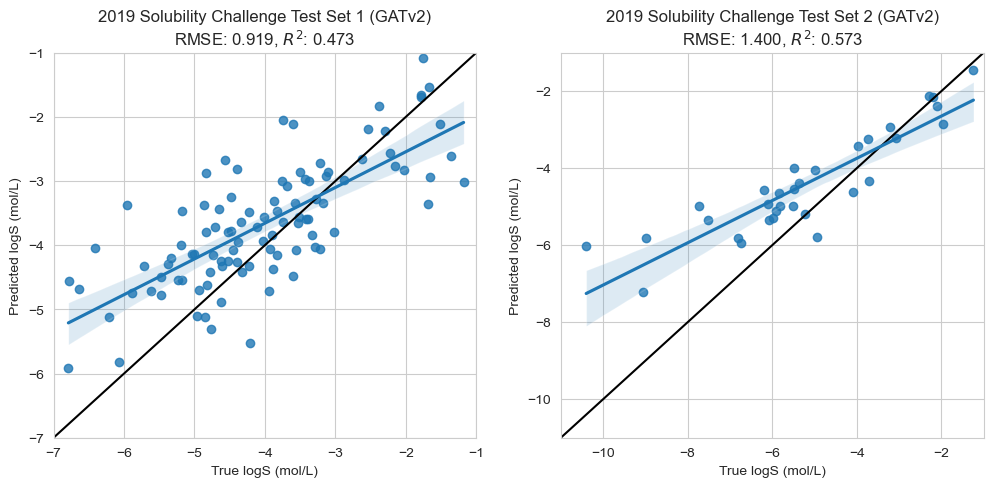

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

model_name = "GATv2"
min_ax1, max_ax1 = -7, -1
min_ax2, max_ax2 = -11, -1

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST1.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST2.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst2
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax2
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)

ax1.set_title(f"2019 Solubility Challenge Test Set 1 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST1.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST1.y, pred_tst1):.3f}")
ax2.set_title(f"2019 Solubility Challenge Test Set 2 ({model_name})\n"
              f"RMSE: {mean_squared_error(TST2.y, pred_tst2, squared=False):.3f}, $R^2$: {r2_score(TST2.y, pred_tst2):.3f}")

# plt.axis("equal")